# TP Final de Aprendizaje Profundo
## Guarnieri Victoria
___
### Consigna
Mediante el modelo de redes neuronales que el alumno considere pertinente, deberá resolver el problema de clasificación de rostros de Labeled Faces in the Wild (LFW) usando un sub-conjunto del dataset homónimo disponible en scikit-learn.

**NOTA**: Solo se usarán las 7 categorías más representativas de ese dataset.

Dentro del archivo TP Final - Aprendizaje profundo.zip el alumno encontrará una jupyter notebook .ipynb con una visualización simple del problema a resolver

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html

### Desarrollo del TP
Se resolverá el problema en cuestión utilizando una **Red Neuronal Convolucional (CNN)**, usando como base el archivo .jpynb brindado por el docente.

___
### Librerías

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.metrics import MSE
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.losses import categorical_crossentropy # Función de costo
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Dataset de la consigna
from sklearn.datasets import fetch_lfw_people

2023-07-31 22:27:34.490349: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-31 22:27:34.571508: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-31 22:27:34.572955: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 22:27:36.200511: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


___
### Se cargan el conjunto de datos LFW
Utilizaremos solo imagenes de 7 personas
- ```min_faces_per_person = 70```: 70 imagenes disponibles como mínimo
- ```resize = 0.5```: reducción a la mitad del tamaño de las imágenes

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person = 70, resize = 0.5)

___
### Inspección de los tamaños
Usando el metodo ```shape()```
* n_samples: número de muestras
* h: altura de la imagen
* w: ancho de la imágen

In [3]:
n_samples, h, w = lfw_people.images.shape

### Preparación de datos y etiquetas

In [4]:
# Datos sin divir en subconjuntos
# Datos de entrda
X = lfw_people.images

# Etiquetas y nombres
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

# Impresión de los datos recolectados
print("Tamaño del conjunto de datos:")
print(" • h, w: (%d, %d)" % (h, w))
print(" • n_samples: %d" % n_samples)
print(" • n_classes: %d" % n_classes)

Tamaño del conjunto de datos:
 • h, w: (62, 47)
 • n_samples: 1288
 • n_classes: 7


___
### Algunas funciones para graficar

In [5]:
def plot_gallery(images, number, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize = (1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom = 0, left = 0.01, right = 0.99, top = 0.90, hspace = 0.35)
    for i in range(number):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title(y, target_names):
    return "%s" % (target_names[y])

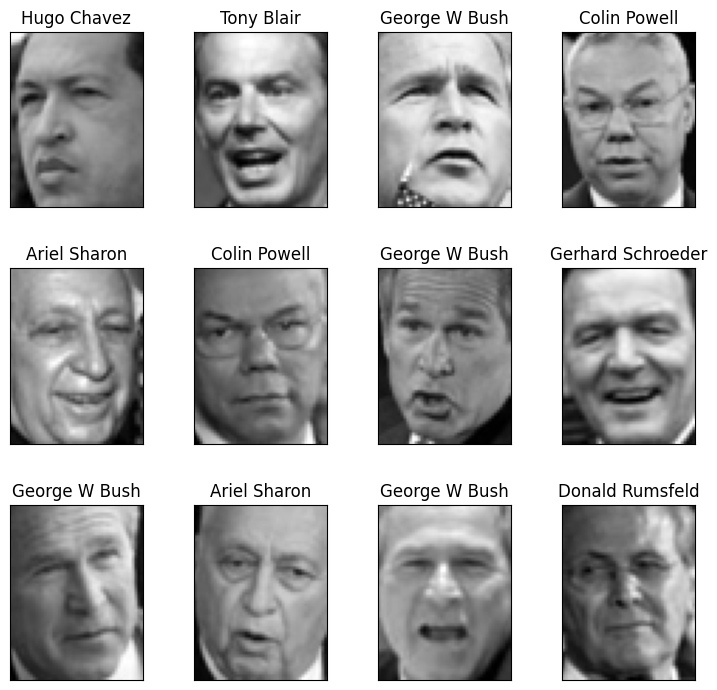

In [6]:
titles = [title(y[i], target_names) for i in range(20)]
plot_gallery(X, 12 , titles, h, w)

In [7]:
#Features: numeros reales, entre 0 y 255
print(X[0])

[[0.9973857  0.9973857  0.99607843 ... 0.26928106 0.23267974 0.20261438]
 [0.9973857  0.99607843 0.99477124 ... 0.275817   0.24052288 0.20915033]
 [0.9882353  0.97647065 0.96732026 ... 0.26928106 0.24052288 0.21830066]
 ...
 [0.3372549  0.2784314  0.20522876 ... 0.4117647  0.39869282 0.37908497]
 [0.30980393 0.2522876  0.19738562 ... 0.39607847 0.39607844 0.37254906]
 [0.28496733 0.24705882 0.19869281 ... 0.38431373 0.3869281  0.3803922 ]]


___
### Parámetros de entrenamiento
- **Learning Rate**: hiperparámetro. Tasa a la cual la RN aprende en cada paso de backpropagation. Valor estandar = 1.0

In [8]:
lr = 1.0

- **Numero de épocas**: una época es una iteración en la cual la RN ve el total de ejemplos de entrenamiento

In [9]:
epochs = 10

- **Tamaño de batch**: la red va a ver 256 ejemplos hacia adelante, se calcula el error medio, y ese error medio se retropropaga. El proceso se repite hasta completar una epoca.

In [10]:
batch_size = 32

- **Semilla** de la generación pseudoaleatoria de los números (así obtengo el mismo rtado en distintas ejecuciones)

In [11]:
np.random.seed(14)

___
### División de los datos de ```X``` en subconjuntos
Usando el método ```train_test_split()```, se obtienen los conjuntos de entrenamiento (80%) y validación (20%)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

___
### Preparación de los datos
Observar que las imágenes están en **escala de grises**. 

Se convierten los datos a un tipo de valor decimal (```float32```), y se divide por el 'tope' de la escala de grises (255). 
- 0: negro
- 1: blanco

In [13]:
#x_train = x_train.astype('float32') / 255.0
#x_test = x_test.astype('float32') / 255.0

In [14]:
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes) #one-hot encoding

### Modelo

In [15]:
x_train.shape

(1030, 62, 47)

1. **Capa de input**

    Se debe expandir la capa de input, que tiene ```shape = (None, 62, 47)```, porque en el próximo paso (primera capa convolucional) debería recibir una shape ```(None, 62, 47, 1)```

In [16]:
input_layer = Input(shape = x_train.shape[1:])
new_input_layer = tf.expand_dims(input_layer, axis = -1)

# Para ver la nueva dimensión (None, 62, 47, 1)
print(new_input_layer)

KerasTensor(type_spec=TensorSpec(shape=(None, 62, 47, 1), dtype=tf.float32, name=None), name='tf.expand_dims/ExpandDims:0', description="created by layer 'tf.expand_dims'")


2. **Capas convolucionales de 2 dimensiones**

    Usando ```Conv2D()```
    - 1er argumento: nro de kernels
    - 2do argumento: dimensión de los kernels
    - 3er argumento: función de activación (una rampa)

In [17]:
conv_1 = Conv2D(32, (3, 3), activation='relu') (new_input_layer)
conv_2 = Conv2D(64, (3, 3), activation='relu') (conv_1)

3. **Capa de MaxPooling2D**

    Se queda con el pixel de mayor valor

In [18]:
pool_1 = MaxPooling2D(pool_size = (2, 2)) (conv_2)

4. **Capa de Dropout**

    Es un dropout al 25%, cuyo objetivo es:
    - ↓ complejidad computacional en entrenamiento
    - ↓ sobreajuste

In [19]:
dropout_1 = Dropout(0.25) (pool_1)

5. **Capa de Flatten**

    Aplasta las dimensiones de la red, para poder pasarlo por una capa densa

In [20]:
flatten_1 = Flatten() (dropout_1)

6. **Capa Densa y capa Dropout nro 2 al 25%**

In [21]:
dense_1 = Dense(100, activation = 'relu') (flatten_1)
dropout_2 = Dropout(0.25) (dense_1)

7. **Capa de output**

In [22]:
output_layer = Dense(n_classes, activation = 'softmax') (dropout_2)

### Modelo

In [23]:
model_conv = Model(input_layer, output_layer)

___
### Configuración del proceso de entrenamiento

Usando la función ```compile()```
- ```optimizer```: optimizador que se usará
- ```loss```: función de costo
- ```metrics```: métricas que se utilizarán para evaluar el rendimiento del modelo (accuracy y error cuadrático medio)

También se imprime un resumen del modelo mediante la función ```summary()```

In [24]:
model_conv.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics = ['acc', 'mse'])
model_conv.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 62, 47)]          0         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 62, 47, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 60, 45, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 43, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 21, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 29, 21, 64)        0         
                                                             

___
### Entrenamiento del modelo

In [25]:
start_time = time.time()
history_conv = model_conv.fit(x_train, 
                              y_train, 
                              epochs = epochs, 
                              batch_size = batch_size, 
                              validation_data = (x_test, y_test), 
                              shuffle = True, 
                              verbose = 1)
end_time = time.time()
print('\nElapsed Dense Model training time: {:.5f} seconds'.format(end_time-start_time))

Epoch 1/10
33/33 [==============================] - 11s 291ms/step - loss: 1.7778 - acc: 0.3757 - mse: 0.1137 - val_loss: 1.5831 - val_acc: 0.4612 - val_mse: 0.1033
Epoch 2/10
33/33 [==============================] - 9s 279ms/step - loss: 1.6667 - acc: 0.4039 - mse: 0.1078 - val_loss: 1.5208 - val_acc: 0.5504 - val_mse: 0.0989
Epoch 3/10
33/33 [==============================] - 8s 251ms/step - loss: 1.4276 - acc: 0.4748 - mse: 0.0931 - val_loss: 1.3117 - val_acc: 0.5853 - val_mse: 0.0869
Epoch 4/10
33/33 [==============================] - 8s 234ms/step - loss: 1.0714 - acc: 0.6068 - mse: 0.0727 - val_loss: 0.9407 - val_acc: 0.6938 - val_mse: 0.0624
Epoch 5/10
33/33 [==============================] - 9s 266ms/step - loss: 0.7759 - acc: 0.7194 - mse: 0.0540 - val_loss: 0.7149 - val_acc: 0.7364 - val_mse: 0.0484
Epoch 6/10
33/33 [==============================] - 9s 282ms/step - loss: 0.6001 - acc: 0.8019 - mse: 0.0412 - val_loss: 0.6403 - val_acc: 0.8023 - val_mse: 0.0413
Epoch 7/10
33/3

___
### Evaluación del proceso

In [26]:
history_conv.history.keys()

dict_keys(['loss', 'acc', 'mse', 'val_loss', 'val_acc', 'val_mse'])

**Gráfico del error cuadrático medio**

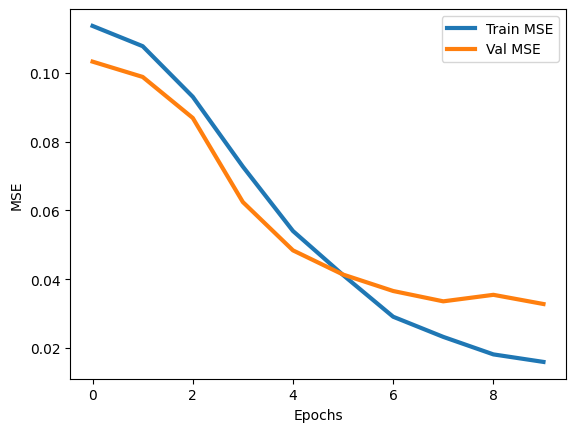

In [27]:
plt.plot(history_conv.history['mse'], linewidth = 3, label = 'Train MSE')
plt.plot(history_conv.history['val_mse'], linewidth = 3, label = 'Val MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(loc = 'upper right')
plt.show()

**Gráfico de la accuracy**

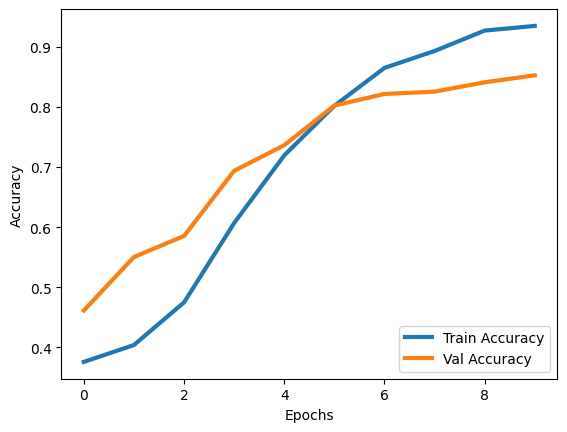

In [28]:
plt.plot(history_conv.history['acc'], linewidth = 3, label = 'Train Accuracy')
plt.plot(history_conv.history['val_acc'], linewidth = 3, label = 'Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')